# [ Introduction](Introduction.ipynb)

# [ Données météorologiques](Donnes_meteo.ipynb)

# Modèle thermique utilisé

Pour simplifier les calculs, nous avons modélisé le bâtiment étudié comme un simple bâtiment rectangulaire avec les caractéristiques suivantes : 
- 5 murs verticaux avec 2 couches : béton et isolation intérieure.
- 1 mur vertical vitré.
- Les infiltrations d'air sont prises en compte.
- Système HVAC qui contrôle la température de l'air interieur.

La figure 1 présente les hypothèses retenues.


![cube](./Figures/03_cube_principle.svg)
> Figure 1. Pièce ventilée simple (5 murs à deux couches et 1 fenêtre en verre) équipée d'un système HVAC qui agit comme un contrôleur proportionnel.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

Les dimensions et les surfaces du bâtiment étudie sont les suivantes  :
- $l=2.8 \: \mathrm{m}$ - hauteur du bâtiment;
- $S_g= 32.4 m²$   - surface de la fenêtre en verre;
- $S_c = S_i = 142.18 m²$   - la surface des 5 murs (béton et isolation).

In [2]:
l = 2.8               # m length of the room
Sg = 32.4 ##l**2 15.36         # m² surface of the glass wall
Sc = Si = 142.18   # m² 106.44 surface of concrete & insulation of the 5 walls

## Propriétés physico-thermiques

Dans cette section, nous décrivons les caractéristiques thermiques et physiques des éléments utilisés dans ce projet.

### Propriétés physico-thermiques : air

On peut commencer par definir les propriétés de l'air dans le SI :

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


## Propriétés physico-thermiques : concrete et isolation avec polystrène extrudé

Nous définissons ici les propriétés et les géométries utilisées pour le béton et l'isolation.
Dans ce travail, nous évaluerons la différence entre l'utilisation de 2 matériaux d'isolation. Pour commencer, nous considérons des **murs** avec 2 couches : l'isolation à l'intérieur (couche 2), et le béton à l'extérieur (couche 1), qui sont modélisés comme des résistances discrétisées, ainsi que les résistances équivalentes de conduction et de convection vues dans la figure 1.
La surface vitrée est constituée d'une seule couche de verre avec les mêmes résistances équivalentes au transfert de chaleur que celles utilisées pour les murs.

![wall](./Figures/02_wall.svg)

> Figure 2. Composition du mur

Les caractéristiques de chaque élément sont décrites ci-dessous, où nous définissons deux types d'isolation : le polystyrène extrudé, en tant que matériau conventionnel, et la laine de chanvre, qui est le matériau que nous voulons utiliser pour les travaux de rénovation et dont nous voulons connaître la performance énergétique. Dans ce première partie, on anayse juste le polystyrène extrudé.

In [4]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': Sc}
## insulation polystrène extrudé 
insulation = {'Conductivity': 0.027,
              'Density': 55,
              'Specific heat': 1450,
              'Width': 0.1,
              'Surface': Sc}
## insulation laine de chanvre
insulation2 = {'Conductivity': 0.042,
              'Density': 35,
              'Specific heat': 1700,
              'Width': 0.1,
              'Surface': Sc}
glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 750,
         'Width': 0.04,
         'Surface': Sg}
## on a changué l'ordre car pour nous, l'isolation est à l'exterieur
wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass},
                              orient='index')
wall2 = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation2,
                               'Glass': glass},
                              orient='index')
#wall
wall2

,Conductivity,Density,Specific heat,Width,Surface
Layer_out,1.400,2300.0,880,0.20,142.18
Layer_in,0.042,35.0,1700,0.10,142.18
Glass,1.400,2500.0,750,0.04,32.40


## Propietées radiatives 

Toutes les surfaces peuvent être définies par leurs caractéristiques radiatives, en particulier l'absorptivité $\alpha$, qui correspond à la quantité d'énergie incidente sur la surface qui est absorbée, et l'émissivité $\epsilon$, qui correspond à l'énergie émise par la surface à une certaine température, et la transmittance  $\tau$, qui correspond à l'énergie incidente traversant une surface. 
- $\epsilon$ emmisivité en ondes longues du béton (entre normal et rugueux) et du verre pyrex ;
- $\alpha_{w}$ Absorption du rayonnement solaire en ondes courtes  pour les surfaces blanches et lisses ;
- $\tau$ ondes courtes transmittance du verre avec $0.4 m$ d'epaisseur
- $\alpha_{g}$ onde courte absorptivité et transmittance d'une vitre bleue réfléchissante.

In [5]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
τ_wSW = 0.9
α_wSW = 0.57    #absorbtance in short wave

La constante Stefan-Boltzmann :

In [6]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


## Réseau thermique

Pour la simulation du projet, nous avons utilisé le modèle de circuit thermique analogue à un système électrique illustré à la figure 3, pour modéliser les éléments et les apports énergétiques du bâtiment. 
Les réseaux (ou circuits) thermiques sont des graphes dirigés pondérés dans lesquels :
- les **nœuds**  représentent les températures, $\theta_i$, de points géométriques, de surfaces ou de volumes ;
- les **branches**  orientées représentent les taux de flux de chaleur thermique, $q_j$, entre les nœuds de température.

![basic_TC](./Figures/A01_Basic_thermal_circuit.svg)
> Figure 3. Modèle du réseau thermique.

Un réseau thermique possède au moins une branche orientée, $q$, et un noeud, $\theta$.

Dans un noeud, il y a une capacité thermique, $C_i$, (qui peut être positive ou nulle) et une source de flux de chaleur, $\dot Q_i$, (qui peut être nulle).

Sur une branche, il y a un conductane, $G_j > 0$, (qui doit être strictement positif) et une source de température, $T_j$ (qui peut être nulle).

Le problème de l'analyse des circuits thermiques (ou le problème de la simulation, ou le problème direct) est :

**Données d'éntrée** :
- matrice d'incidence $A$ qui indique comment les nœuds sont connectés par des branches orientées ;
- matrice diagonale de conductance $G$ ;
- matrice diagonale de capacité $C$ ;
- vecteur source de température $b$ ;
- vecteur source de flux de chaleur $f$ ;

**Données de sortie** :
- le vecteur de température $\theta$ 
- le vecteur de débit $q$.


Pour le modèle illustré à la figure 1, le transfert de chaleur s'effectue :
- à travers les murs (béton et isolation), 
- à travers la fenêtre en verre,
- par la ventilation,
- à partir de sources auxiliaires intérieures,
- par le système de chauffage, de ventilation et de climatisation.

Le système HVAC est modélisé comme un régulateur proportionnel. Il y a un échange radiatif à ondes longues entre le mur et la fenêtre en verre. Les sources sont les suivantes
- sources de température :
 - air atmosphérique extérieur ;
 - point de consigne de la température de l'air intérieur ;
- sources de débit de chaleur :
 - rayonnement solaire sur les parois extérieures et intérieures ;
 - gains de chaleur auxiliaires dans la zone thermique.

![heat_processes](./Figures/03_heat_process.svg)
> Figure 4. Processus thermiques pour le bâtiment cubique illustré à la figure 1.

![thermal_circuit](./Figures/03_therm_circ.svg)
> Figure 5. Circuit thermique pour le bâtiment cubique illustré à la figure 1 et les processus thermiques illustrés à la figure 2. *Remarque :* la discrétisation de l'espace des murs est faite pour des raisons de simplicité.

## Conductivités thermiques

On travail avec les conductivités thermiques par conduction et convection, en considerant les conductivités interieurs et exterieurs. 

### Conductance equivalent par convention et conduction

#### Conduction
Les conductances 1, 2, 3 et 4 du circuit thermique de la figure 3 modélisent le transfert de chaleur par conduction. Les conductances de conduction, en W/K, sont de la forme suivante :
$$G_{cd} = \frac{\lambda}{w}S$$
où :

- $\lambda$ - conductivité thermique ;
- $w$ - largeur du matériau, m ;
- $S$ - surface de la paroi, m².

In [7]:
# conduction PE
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

,Conductance
Layer_out,995.2600
Layer_in,38.3886
Glass,1134.0000


#### Convection
Les conductances 0, 6 et 7 modélisent le transfert de chaleur par convection. Les conductances de convection, en W/K, sont de la forme :
$$G_{cv} = {h S}$$
 où :
 
- $h$ - est le coefficient de convection;
- $S$ - surface de la paroi m².

In [8]:
#coeficients de convection utilisés 
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


Les conductances pour les murs et les verres sont :

In [9]:
# convection PE
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

### Rayonnement à ondes longues : facteurs de vues à l'intérieur du bâtiment

Les facteurs de vue, également appelés facteurs de forme ou coefficients de transfert radiatif, sont des coefficients utilisés dans l'analyse du transfert de chaleur par rayonnement entre des surfaces. Ces coefficients décrivent la fraction de rayonnement émise par une surface qui est reçue par une autre surface.
Lorsque l'on traite des problèmes de transfert de chaleur par rayonnement entre des surfaces, il est essentiel de comprendre comment le rayonnement émis par une surface influe sur d'autres surfaces dans son environnement. Les facteurs de visualisation permettent de déterminer la quantité relative de rayonnement échangée entre différentes surfaces. 

Le facteur de vue entre le béton et le verre de notre système est : 

In [10]:
# view factor wall-glass
Fwg = glass['Surface'] / concrete['Surface']

Pour le calcul, on utilise la température moyenne $\bar{T}$, mesurée en kelvins pour le calcul final de la conductance équivalente :

$$\bar{T} =\sqrt[3]{ \frac{(T_1^2 + T_2^2)(T_1 + T_2)}{4}}$$.

L'évaluation de la température moyenne, $\bar{T}$, nécessite les valeurs des températures de surface, $T_1$ et $T_2$. Une première estimation peut être utilisée (puis un processus itératif, pour une évaluation plus précise) mais pour ce projet on define un valeur fixe.

Un processus de linéarisation est fait pour le calcul des conductances, en W/K, pour l'échange de chaleur radiatif qui sont :

$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$$$ G_{2} = 4 \sigma \bar{T}^3 F_{2,1} S_2$$

$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

 


In [11]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

La conductance équivalente, en W/K, pour l'échange radiatif de chaleur à ondes longues entre le mur et la fenêtre en verre est la suivante :
$$G = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [12]:
# Equivalent conductance for the radiative long-wave heat exchange
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)
GLW

160.5435603400496

### Advection

L'advection est le processus d'échange d'air avec l'air extérieur qui est également modélisé comme une conductance. 
Le débit volumétrique de l'air, en m³/s, qui traverse le bâtiment est de :

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

où :
- $\mathrm{ACH}$ changements d'air par heure est le taux d'infiltration d'air, 1/h ;
- $3600$ - nombre de secondes dans une heure, s/h ;
- $V_a$ - volume d'air dans la zone thermique, m³.

In [13]:
# ventilation flow rate
Va = (Sc+Sg)*l              # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltrations
Va

488.824

Le débit net que le bâtiment reçoit par advection, c'est-à-dire en introduisant de l'air extérieur à la température $T_o$ et en extrayant de l'air intérieur à la température $\theta_i$ par ventilation et/ou infiltration d'air, est :

$$q_v = \dot{m}_a c_a (T_o - \theta_i) = \rho_a c_a \dot{V}_a (T_o - \theta_i)$$

où :
- $\dot{m}_a$ est le débit massique de l'air, en kg/s ;
- $\dot{V}_a$ - débit volumétrique, m³/s ;
- $c_a$ - capacité thermique spécifique de l'air, J/kg-K ;
- $\rho_a$ - densité de l'air, kg/m³ ;
- $T_o$ - température de l'air extérieur, °C (notée en majuscule parce qu'il s'agit d'une *source de température* ou d'une *variable d'entrée*) ;
- $\theta_i$ - température de l'air intérieur, °C (notée en minuscule car il s'agit d'une *température dépendante* ou d'une *variable de sortie*).

Par conséquent, la conductance de l'advection par ventilation et/ou infiltration en W/K, est de :
$$G_v = \rho_a c_a \dot{V}_a$$

In [14]:
T0 = 0
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot
q_av = Gv *(T0-20)
q_av     ## advection flux for ventilation

-3258.826666666667

### Contrôleur proportionnel

Dans la représentation la plus simple, le système HVAC peut être considéré comme un régulateur proportionnel qui ajuste le débit de chaleur $q_{HVAC}$ afin de contrôler la température intérieure $\theta_i$ à sa valeur de consigne $T_{i,sp}$. Le débit de chaleur, en W, injecté par le système HVAC dans l'espace contrôlé est :
$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

où :
- $K_p$ est le gain proportionnel, W/K ;
- $T_{i, sp}$ - température intérieure point de consigne °C (mayuscule car donné).
- $\theta_i$ - température intérieure, °C (minuscule car sortie)

Cette équation montre que le régulateur proportionnel peut être modélisé par une source de température, $T_{i, sp}$, et une conductance, $K_p$. Si le gain du régulateur tend vers :
- l'infini, $K_p \rightarrow \infty$, alors le régulateur est parfait, $\theta_i \rightarrow T_{i, sp}$.
- zéro, $K_p \rightarrow 0$, le régulateur n'agit pas et le bâtiment fonctionne librement, c'est-à-dire $q_{HVAC} = 0$.

In [15]:
# P-controler gain
Kp = 0 ### mettre très grand gain pour controler ex. 1e5 
# correspond à conductance G_11

### Conductances en série et/ou en parallèle
Si les conductances sont connectées à des nœuds de température qui n'ont pas de source de capacité et/ou de débit, les conductances peuvent être considérées comme en série ou en parallèle (en fonction de la connexion). Considérons, par exemple, le côté extérieur de la fenêtre en verre (figure 3) : la conductance de convection extérieure et la conductance de conduction (correspondant à la moitié de la largeur de la fenêtre) sont en série :

$$ G_{gs} = \frac{1}{1/G_{g,cv.out } + 1/(2 G_{g,cd})} = 
\frac{1}{\frac{1}{h_{out} S_g} + \frac{w / 2}{\lambda S_g}}
$$

In [16]:
# glass: convection outdoor & conduction PE
Ggs = float(1 / (1 / Gg.loc['h', 'out'] + 1 / (2 * G_cd['Glass'])))
Ggs

596.8421052631579

### Matrice de capacités : Capacités thermiques

#### Murs
Les capacités thermiques du système servent à modéliser l'inertie des matériaux du revêtement.
Les capacités thermiques de la paroi, en J/kg, sont :

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

où :
- $m_w = \rho_w w_w S_w$ est la masse de la paroi, en kg ;
- $c_w$ - capacité thermique spécifique, J/(kg⋅K) ;
- $\rho_w$ - densité, kg/m³ ;
- $w_w$ - largeur du mur, m ;
- $S_w$ - surface de la paroi, m².

In [17]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C

Layer_out    57554464.0
Layer_in      1133885.5
Glass         2430000.0
dtype: float64

#### Air
De même, la capacité thermique de l'air, en J/kg, est :


$$C_a = m_a c_a = \rho_a c_a V_a$$.


où :
- $m_a = \rho_a V_a$ est la masse de l'air, en kg ;
- $\rho_w$ - densité de l'air, kg/m³ ;
- $c_a$ - capacité thermique spécifique de l'air, J/(kg⋅K) ;
- $V_a$ - volume de l'air dans la zone thermique, m³.

In [18]:
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

,Capacity
Layer_out,57554464.0
Layer_in,1133885.5
Glass,2430000.0
Air,586588.8


### Source de temperatures 
Les sources de température modélisent des températures qui varient indépendamment de ce qui se passe dans le circuit thématique ; ce sont des entrées du modèle physique. En général, les sources de température sont
- la température de l'air extérieur et du sol
- la température des espaces adjacents dont la température est contrôlée ;
- la température de consigne.

On utilise pour une temperature exterieur fixé parce que on est dans la simulation statique.

#### Température de consigne

La température de consigne ne dépend pas des processus de transfert de chaleur de la zone thermique analysée. Si le système HAVC peut fournir le débit de chaleur :

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

où
- $K_p$ est le gain proportionnel, W/K ;
- $T_{i, sp}$ - température intérieure point de consigne, °C ;
- $\theta_i$ - température intérieure, °C,

le point de consigne de la température intérieure, $T_{i, sp}$, peut être modélisé par une source de température.

###  Sources de débit de chaleur
Les sources de débit de chaleur modélisent des débits qui varient en fonction de ce qui se passe dans le circuit thématique. Ce sont des entrées du modèle physique. En général, les sources de flux de chaleur sont
- le rayonnement solaire absorbé par les parois ;
- les sources auxiliaires internes.

#### Chaleur absorbé par les murs 

##### Mur exterieur

Le rayonnement absorbé par la surface extérieure du mur est :

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$.

##### Mur interieur

La radiation absorbé pour les murs interiurs est modélisé par : 

$$\Phi_o = \tau_{g,SW} \alpha_{w,SW} S_g E_{tot}$$


Pour les calculs de flux de chaleur, nous utilisons les coefficients $\alpha$, $\epsilon$ et $\tau$ et la quantité d'irradiation sur le site, nous appelons donc les résultats de la partie météorologique précédente : 

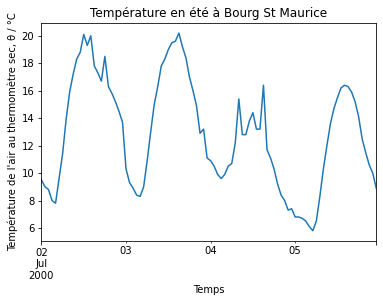

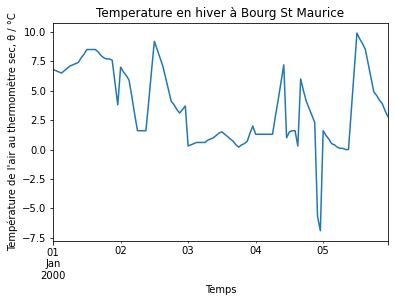

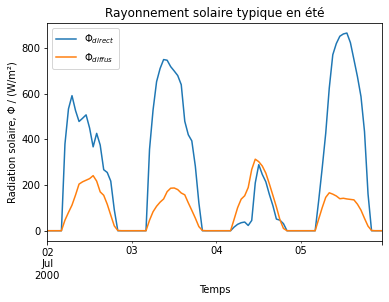

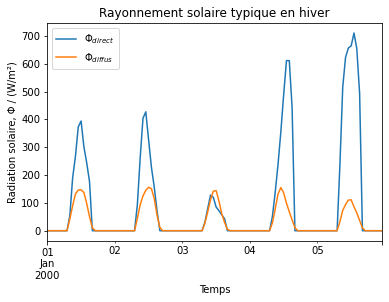

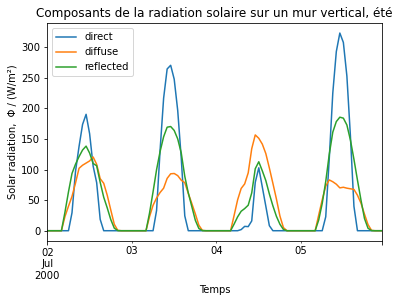

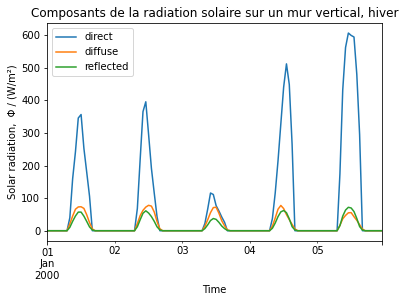

In [19]:
%run "Donnes_meteo.ipynb"

In [20]:
 # [Φo, Qa, Φi , Φa] pour l'été
P = 30          # occupation 
Φoe = α_wSW*Sc*mean_ete['dir_n_rad']  #solaire radiation murs
Qae = 70*P       #flux de chaleur de une personne fois l'occupation
Φae = α_gSW*Sg*mean_ete['dir_n_rad']

In [21]:
# solar radiation absorbed by the indoor surface of the wall
Φie = τ_gSW * α_wSW * Sg * mean_ete['dir_n_rad']

**Les flux de chaleur pour l'hiver :**

In [22]:
 # [Φo, Qa, Φi , Φa] pour l'hiver
P = 30          # occupation 
Φoh = α_wSW*Sc*mean_hiver['dir_n_rad']  #solaire radiation murs
Qah = 58*P       #flux de chaleur de une personne fois l'occupation
Φah = α_gSW*Sg*mean_hiver['dir_n_rad']
# solar radiation absorbed by the indoor surface of the wall
Φih = τ_gSW * α_wSW * Sg * mean_hiver['dir_n_rad']

##### Sources internes

Pour les occupations, nous considérons une occupation moyenne de 30 personnes émettant chacune 58 W/m² de flux de couleur et obtenons :

$Q_a = 70*P $

## Matrice d'indices A

La matrice A définit l'interaction entre les flux de chaleur des différents nœuds. Lorsque le nœud a un flux entrant, l'indice est positif et lorsque l'indice est négatif, on considère que le flux quitte le nœud. S'il n'y a pas de flux dans une direction donnée, l'indice est égal à 0.

In [23]:
A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6

# np.set_printoptions(suppress=False)
# pd.DataFrame(A)

## Matrice de Conductances 

La matrice des conductances est définie comme une matrice diagonnalle pour chaque conductance du système.

In [24]:
G = np.diag(np.hstack(
    [Gw['out'],
    2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
    2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
    GLW,
    Gw['in'],
    Gg['in'],
    Ggs,
    2 * G_cd['Glass'],
    Gv,
    Kp]))

np.set_printoptions(precision=3, threshold=16, suppress=True)
pd.set_option("display.precision", 1)
pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,10,11
0,3554.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1990.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1990.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,76.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,76.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,160.5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1137.4,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,259.2,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,596.8,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2268.0,0.0,0.0


In [25]:
neglect_air_glass = False

if neglect_air_glass:
    C = np.diag([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                 0, 0])
else:
    C = np.diag([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                 C['Air'], C['Glass']])

# pd.set_option("display.precision", 3)
# pd.DataFrame(C)

## Vecteurs de sources de température 
La taille du vecteur source de température est la même que le nombre de conductances mais nous ne définissons les valeurs qu'aux nœuds qui ont une source telle que la température extérieure ou la température de consigne correspondant aux nœuds $0, 8, 10$ et $11$.

In [26]:
b = np.zeros(12)        # branches
b[[0, 8, 10, 11]] = 1   # branches with temperature sources       # temperature sources
b[[0, 8, 10]] = 10      # outdoor temperature
b[[11]] = 20           # indoor set-point temperature
print(f'b = ', b)

b =  [10.  0.  0.  0.  0.  0.  0.  0. 10.  0. 10. 20.]


## Vecteurs pour les sources de chaleur 
La taille de la matrice des sources de chaleur est égale au nombre de nœuds, mais seuls les nœuds avec une source de chaleur sont définis.

In [34]:
f = np.zeros(8)         # nodes
f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
print(f'f = ', f)



f =  [1. 0. 0. 0. 1. 0. 1. 1.]


## Vecteur de sortie

Nous définissons le vecteur qui donne les valeurs de température aux nœuds, mais nous ne nous intéressons qu'à la température intérieure du nœud 6.

In [35]:
y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)


y =  [0. 0. 0. 0. 0. 0. 1. 0.]


## Représentation de l'espace d'état
Pour la simulation dynamique, nous devons discrétiser le système afin d'obtenir les valeurs d'état qui décrivent la variation du système. Pour le faire, le système DAE 
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
peut être transformé dans une répresentation spatiel et d'état : 
$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

In [36]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, C, b, f, y)
θs = ['θ1', 'θ3', 'θ6', 'θ7']       # state temperature nodes
uT = ['q0', 'q8', 'q10', 'q11']     # temperature sources
uQ = ['θ0', 'θ4', 'θ6', 'θ7']       # flow sources
u = uT + uQ                         # inputs
y = ['θ6']                          # output

Les résultats de cette section seront utilisés dans les sections suivantes du rapport.

In [30]:
#pd.DataFrame(As, index=θs, columns=θs)

In [31]:
#pd.DataFrame(Bs, index=θs, columns=u)

In [32]:
#pd.DataFrame(Cs, index=y, columns=θs)

In [33]:
#pd.DataFrame(Ds, index=y, columns=u)

# [Implementation et resultats : simulation stationnaire, polystrène expansé ](Stationnaire_cas.ipynb)

# [ Implementation et resultats : simulation stationnaire, laine de mouton ](laine.ipynb)

# [ Estimation degre-heures](degre-hours.ipynb)

# [ Modèle Mathematique, implementation et resultats : simulation stationnaire à répresetation état-spatiel ](state-space.ipynb)

# [ Simulation dynamique ](simulation_dynamique.ipynb)

# [Simulation dynamique : changer entre modèles](heat-cool.ipynb)

# [Simulation dynamique : Contrôleur avec feedback](feedback_control.ipynb)


---
